In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
df = pd.read_csv("creditcard.csv")   # change filename if needed
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [4]:
df['Class'].value_counts()


,count
Class,
0.0,1983
1.0,2


In [5]:
X = df.drop('Class', axis=1)
y = df['Class']


In [7]:
import numpy as np

# Filter out rows where y is NaN
valid_indices = y.dropna().index
X_filtered = X.loc[valid_indices]
y_filtered = y.loc[valid_indices]

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
X_train_lstm = X_train_scaled.reshape(
    X_train_scaled.shape[0],
    X_train_scaled.shape[1],
    1
)

X_test_lstm = X_test_scaled.reshape(
    X_test_scaled.shape[0],
    X_test_scaled.shape[1],
    1
)

print(X_train_lstm.shape)


(1588, 30, 1)


In [10]:
model = Sequential()

model.add(LSTM(
    units=64,
    input_shape=(X_train_lstm.shape[1], 1),
    return_sequences=False
))

model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall', 'AUC']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_lstm,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.0302 - Recall: 0.0000e+00 - loss: 0.4947 - val_AUC: 0.5000 - val_Recall: 0.0000e+00 - val_loss: 0.0217
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.3128 - Recall: 0.0000e+00 - loss: 0.0069 - val_AUC: 0.5000 - val_Recall: 0.0000e+00 - val_loss: 0.0234
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.0971 - Recall: 0.0000e+00 - loss: 0.0021 - val_AUC: 0.5000 - val_Recall: 0.0000e+00 - val_loss: 0.0241
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.4983 - Recall: 0.0000e+00 - loss: 0.0263 - val_AUC: 0.5000 - val_Recall: 0.0000e+00 - val_loss: 0.0238


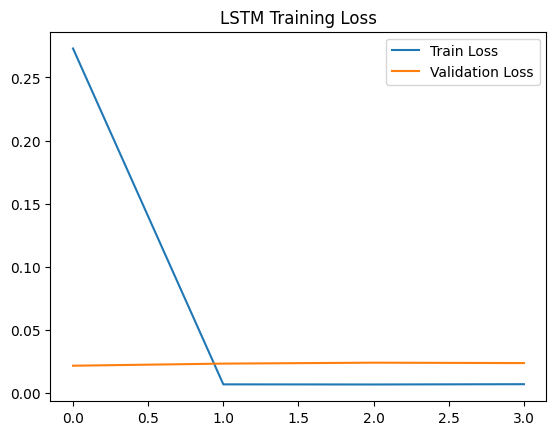

In [13]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("LSTM Training Loss")
plt.show()


In [14]:
y_prob = model.predict(X_test_lstm).ravel()
y_pred = (y_prob > 0.5).astype(int)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [15]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       397

    accuracy                           1.00       397
   macro avg       1.00      1.00      1.00       397
weighted avg       1.00      1.00      1.00       397



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


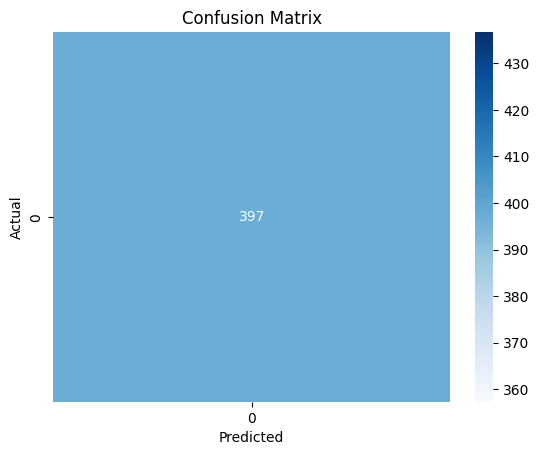

In [16]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


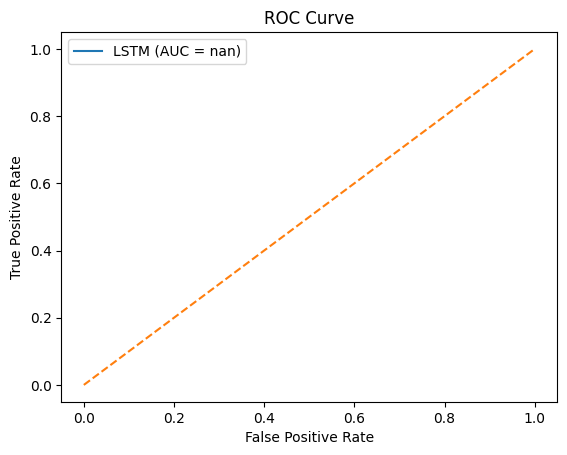

In [17]:
roc_auc = roc_auc_score(y_test, y_prob)

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"LSTM (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [18]:
model.save("lstm_fraud_model.h5")

import joblib
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [19]:
def predict_transaction(features):
    features = np.array(features).reshape(1, -1)
    features = scaler.transform(features)
    features = features.reshape(1, features.shape[1], 1)

    prob = model.predict(features)[0][0]

    if prob > 0.5:
        return "Fraud", prob
    else:
        return "Normal", prob


In [20]:
model.save("lstm_fraud_model.h5")

import joblib
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']